In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv("FREDAPI_KEY")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error,mean_absolute_percentage_error,r2_score


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)



usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)



cuda


In [2]:


df_train = df.iloc[:,0:1].values



train_size = int(len(df_train) * .77)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 4

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [3]:

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [4]:
bidirectional_lstm = BiLSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=bidirectional_lstm.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

In [5]:
for epoch in range(epochs):
    y_pred = bidirectional_lstm(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    bidirectional_lstm.eval()
    with torch.no_grad():
        y_pred = bidirectional_lstm(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  bidirectional_lstm(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RMSE: {train_rmse:.4}; Test RMSE: {test_rmse:.4}')
        

/tmp/ipykernel_42529/1334293925.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_42529/1334293925.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RMSE: 0.411; Test RMSE: 0.1401
Epoch: 1; train_RMSE: 0.3652; Test RMSE: 0.105
Epoch: 2; train_RMSE: 0.3176; Test RMSE: 0.0819
Epoch: 3; train_RMSE: 0.2674; Test RMSE: 0.08893
Epoch: 4; train_RMSE: 0.2166; Test RMSE: 0.1309
Epoch: 5; train_RMSE: 0.1756; Test RMSE: 0.1965
Epoch: 6; train_RMSE: 0.1721; Test RMSE: 0.2772
Epoch: 7; train_RMSE: 0.2086; Test RMSE: 0.3485
Epoch: 8; train_RMSE: 0.2265; Test RMSE: 0.3716
Epoch: 9; train_RMSE: 0.2136; Test RMSE: 0.3542
Epoch: 10; train_RMSE: 0.188; Test RMSE: 0.3161
Epoch: 11; train_RMSE: 0.1666; Test RMSE: 0.2722
Epoch: 12; train_RMSE: 0.1581; Test RMSE: 0.2312
Epoch: 13; train_RMSE: 0.1607; Test RMSE: 0.1977
Epoch: 14; train_RMSE: 0.1677; Test RMSE: 0.173
Epoch: 15; train_RMSE: 0.1737; Test RMSE: 0.1568
Epoch: 16; train_RMSE: 0.1763; Test RMSE: 0.1479
Epoch: 17; train_RMSE: 0.1747; Test RMSE: 0.1454
Epoch: 18; train_RMSE: 0.1692; Test RMSE: 0.1484
Epoch: 19; train_RMSE: 0.1609; Test RMSE: 0.1561
Epoch: 20; train_RMSE: 0.1512; Te

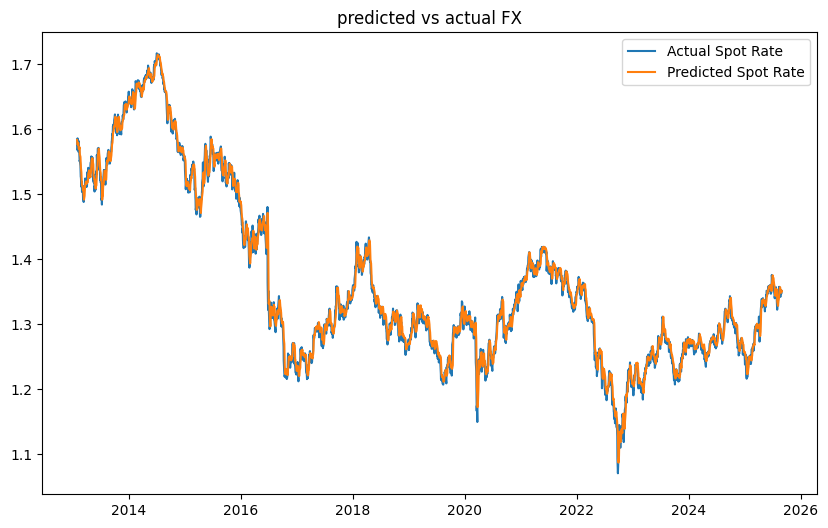

In [6]:
with torch.no_grad():
    pred = bidirectional_lstm(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length:]['Date']


bilstm_comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(bilstm_comparison_df['Date'],bilstm_comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(bilstm_comparison_df['Date'],bilstm_comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predicted vs actual FX")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate_bidirectional_lstm.png")
plt.show()

In [7]:
# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(actual_rescaled,pred_rescaled)
print(f'Mean Absolute Percentage Error: {mape:.4f}')

# R2 Score
r2 = r2_score(actual_rescaled,pred_rescaled)
print(f'R2 Score: {r2*100:2f}%')


# root mean squared error
rmse = root_mean_squared_error(actual_rescaled,pred_rescaled)
print(f'Root Mean Squared Error: {rmse:.4f}')





print(np.round(bilstm_comparison_df,4).head(20))
print(np.round(bilstm_comparison_df,4).tail(20))


Mean Absolute Percentage Error: 0.0063
R2 Score: 99.263769%
Root Mean Squared Error: 0.0116
            Date  Actual Spot Rate  Predicted Spot Rate
10559 2013-01-28            1.5686               1.5832
10560 2013-01-29            1.5751               1.5790
10561 2013-01-30            1.5793               1.5765
10562 2013-01-31            1.5856               1.5758
10563 2013-02-01            1.5744               1.5755
10564 2013-02-04            1.5737               1.5778
10565 2013-02-05            1.5652               1.5789
10566 2013-02-06            1.5655               1.5763
10567 2013-02-07            1.5712               1.5708
10568 2013-02-08            1.5814               1.5694
10569 2013-02-11            1.5668               1.5695
10570 2013-02-12            1.5654               1.5700
10571 2013-02-13            1.5544               1.5719
10572 2013-02-14            1.5502               1.5692
10573 2013-02-15            1.5518               1.5609
10574 2013-0